# Source 
https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import pathlib

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim

# tqdm to enable progress bars for training and testing loops
from tqdm.notebook import tqdm


from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
moods = ['calm', 'energetic', 'happy', 'sad']

In [3]:
files = []
for g in moods:
    for filename in os.listdir(f'data/{g}'):
        file_name = f'data/{g}/{filename}'
        files.append(file_name)

In [4]:
combined_df = pd.concat([pd.read_csv(file) for file in files])

In [5]:
# combined_df.set_index('id')
combined_df.head()

,Unnamed: 0,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,mood
0,0,0.453,0.04360,10,-25.912,0,0.0364,0.990,0.842,0.1110,0.1980,71.987,audio_features,7FyzToHhKG9b9gS19kWg8a,spotify:track:7FyzToHhKG9b9gS19kWg8a,https://api.spotify.com/v1/tracks/7FyzToHhKG9b...,https://api.spotify.com/v1/audio-analysis/7Fyz...,166000,4,calm
1,1,0.437,0.01840,8,-30.783,1,0.0413,0.994,0.930,0.1140,0.0478,119.985,audio_features,5a8V9tjazhBAIbUiFqpu8N,spotify:track:5a8V9tjazhBAIbUiFqpu8N,https://api.spotify.com/v1/tracks/5a8V9tjazhBA...,https://api.spotify.com/v1/audio-analysis/5a8V...,205794,4,calm
2,2,0.366,0.01610,5,-27.355,1,0.0632,0.992,0.951,0.1100,0.1710,49.668,audio_features,3WiissyVFRpCVrqbyPKZxZ,spotify:track:3WiissyVFRpCVrqbyPKZxZ,https://api.spotify.com/v1/tracks/3WiissyVFRpC...,https://api.spotify.com/v1/audio-analysis/3Wii...,121068,4,calm
3,3,0.385,0.00786,0,-25.033,1,0.0546,0.996,0.843,0.0928,0.1290,74.284,audio_features,3orRX2Ms4jy4dU9KqJ9zT1,spotify:track:3orRX2Ms4jy4dU9KqJ9zT1,https://api.spotify.com/v1/tracks/3orRX2Ms4jy4...,https://api.spotify.com/v1/audio-analysis/3orR...,180000,4,calm
4,4,0.381,0.00324,6,-33.019,0,0.0351,0.994,0.885,0.0746,0.0839,101.624,audio_features,536rm114S2ByPbh906pksj,spotify:track:536rm114S2ByPbh906pksj,https://api.spotify.com/v1/tracks/536rm114S2By...,https://api.spotify.com/v1/audio-analysis/536r...,156000,4,calm


In [6]:
import librosa
import os.path

mp3s = {}
c=0
for i in np.unique(combined_df.id):
    fname = f'mp3s/{i}.mp3'
    if os.path.isfile(fname):
        y, sr = librosa.load(fname)
        mood = combined_df.mood[combined_df.id == i]
        mp3s[i] = y, sr, mood
    else:
        print(f"No MP3 for song {i}")
    c+=1
    if c>100:
        break
    


C:\Users\bheim\miniconda3\envs\music_mood\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
C:\Users\bheim\miniconda3\envs\music_mood\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


No MP3 for song 01iY9wuMjG4Q5GMCebu27S
No MP3 for song 01k24g94i1JvkFLQmVEdCd
No MP3 for song 02VHspkXhhH1QCInRWWIfr
No MP3 for song 02Ygu8lo3qSknRpcBnspso
No MP3 for song 02gj0J38nzyO9lNi9mzi3A
No MP3 for song 04fBskFuMgIx0T0ob7uIhd
No MP3 for song 05NYcsjJwOYq4jIiKPVj9p
No MP3 for song 05wIrZSwuaVWhcv5FfqeH0
No MP3 for song 06qUEhhx6jKQmhj2qAkn4H
No MP3 for song 07YAkI4MUIBku8cSJQ2Iz5
No MP3 for song 08Bo3D8B7krvdkQKaAT7Oa
No MP3 for song 092bzgJ0IeH9sWMkBfVM9U
No MP3 for song 0AH6WMe3OlAlUb5miXt2FQ
No MP3 for song 0AkQbXGN4KG34TS7xLrM68
No MP3 for song 0CFtlafteObzOEuJdESQkb
No MP3 for song 0CmXXEwul09Kf8X68lPA5l
No MP3 for song 0EhpEsp4L0oRGM0vmeaN5e
No MP3 for song 0Eqg0CQ7bK3RQIMPw1A7pl
No MP3 for song 0F2LiyHp9E0pAanpfnzHNp
No MP3 for song 0FerZPepEX2Q1UaVeMOlMx
No MP3 for song 0FuTx2s3YH1ppmtiM6l0zI
No MP3 for song 0G71WvIkF2K6HViJeFvOcM
No MP3 for song 0GONea6G2XdnHWjNZd6zt3
No MP3 for song 0GUxlhUfZhTKXtuYPSm7Ha
No MP3 for song 0IZoBFaTUG79KBfKlv8zmG
No MP3 for song 0JExELrTT

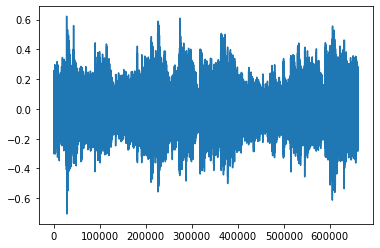

In [7]:
plt.plot(mp3s['0BXq9t3wTA8HMqFPvGxZYf'][0])

In [8]:
len(mp3s)

68

In [9]:
mood_lst = []
y_lst = []

for song in mp3s.keys():
    mood_lst.append(mp3s[song][2])
    y_lst.append(mp3s[song][0])

In [10]:
mp3s[list(mp3s.keys())[0]]

(array([-0.07220786, -0.14678839, -0.16673431, ...,  0.00956032,
        -0.00329892,  0.        ], dtype=float32),
 22050,
 39    sad
 Name: mood, dtype: object)

In [11]:
len(y_lst)

68

In [12]:
len(mood_lst)

68

In [13]:
mood_lst = [m.values[0] for m in mood_lst]

<AxesSubplot:>

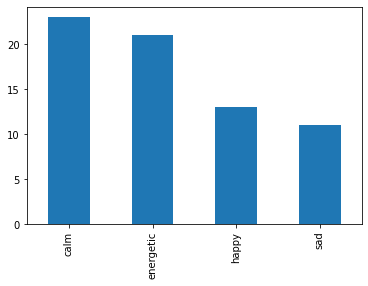

In [14]:
pd.Series(mood_lst).value_counts().plot.bar()

<AxesSubplot:ylabel='None'>

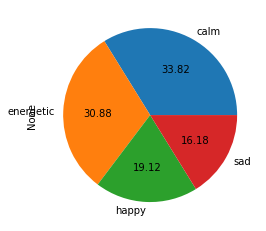

In [15]:
pd.Series(mood_lst).value_counts().plot.pie(autopct='%.2f')

In [16]:
class2idx = {
    'calm':0,
    'energetic':1,
    'happy':2,
    'sad':3
}

idx2class = {v: k for k, v in class2idx.items()}

mood_series = pd.Series(mood_lst).replace(class2idx)

In [17]:
mood_series

0     3
1     1
2     1
3     1
4     2
     ..
63    3
64    1
65    0
66    2
67    1
Length: 68, dtype: int64

In [69]:
X = y_lst
y = mood_series.tolist()

In [26]:
y = mood_series[:,np.newaxis]
print(y.shape)

(68, 1)


C:\Users\bheim\miniconda3\envs\music_mood\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """Entry point for launching an IPython kernel.


In [70]:
X = [torch.Tensor(y[:, np.newaxis]) for y in y_lst]

In [71]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [38]:
# Normalize Input
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)
# X_test = scaler.transform(X_test)
# X_train, y_train = np.array(X_train), np.array(y_train)
# X_val, y_val = np.array(X_val), np.array(y_val)
# X_test, y_test = np.array(X_test), np.array(y_test)

In [39]:
# Visualize Class Distribution in Train, Val, and Test
def get_class_distribution(obj):
    count_dict = {
        "calm": 0,
        "energetic": 0,
        "happy": 0,
        "sad": 0
    }
    
    for i in obj:
        if i == 0: 
            count_dict['calm'] += 1
        elif i == 1: 
            count_dict['energetic'] += 1
        elif i == 2: 
            count_dict['happy'] += 1
        elif i == 3: 
            count_dict['sad'] += 1            
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

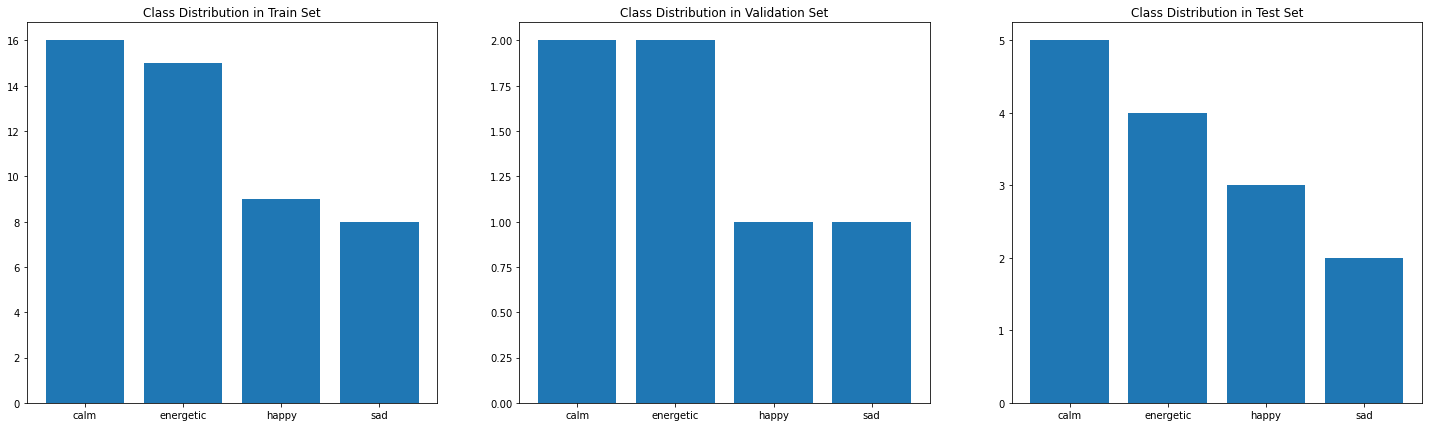

In [40]:
train_count_df =  pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt()
validation_count_df =  pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt()
test_count_df =  pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
axes[0].bar(train_count_df["variable"], train_count_df["value"])
axes[0].set_title('Class Distribution in Train Set')

# Validation
axes[1].bar(validation_count_df["variable"], validation_count_df["value"])
axes[1].set_title('Class Distribution in Validation Set')

# Test
axes[2].bar(test_count_df["variable"], test_count_df["value"])
axes[2].set_title('Class Distribution in Test Set')


In [41]:
# Custom Dataset
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [42]:
def merge(list1, list2, to_tensor=True):
    if to_tensor:
        merged_list = [(torch.Tensor(list1[i]), torch.tensor(list2[i])) for i in range(0, len(list1))]
    else:
        merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list
      

In [72]:
train_dataset = merge(X_train, y_train)
test_dataset = merge(X_test, y_test)
val_dataset = merge(X_val, y_val)

In [65]:
for i in range(0, len(train_dataset)):
    print(len(train_dataset[i][0]))

661500
661500
661500
661500
661501
661501
661500
661500
661500
661500
661501
661500
661500
661500
661500
661500
661500
661501
661500
661500
661500
661501
661500
661500
661500
661501
661500
661501
661500
661500
661501
661500
661501
661500
661500
661501
661500
661501
661500
661500
661500
661500
661500
661501
661500
661500
661501
661500


In [ ]:
## USE THIS EXAMPLE RATHER THAN WHATEVER I HAVE BELOW - https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/

# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 4


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

In [44]:
train_dataset[0][0]

tensor([-0.0273, -0.0193,  0.0206,  ..., -0.0781, -0.0566, -0.0399])

epochs = 10

for i in range(epochs):
    for seq, labels in train_dataset:
#         seq = seq.to(device)
#         labels = labels.to(device)
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
#         model.hidden_cell.to(device)

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%1 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

# for imbalanced data

In [47]:
# Weighted Sampling
# First, we obtain a list called target_list which contains all our outputs. 
# This list is then converted to a tensor and shuffled.
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [48]:
# Then, we obtain the count of all classes in our training set. 
# We use the reciprocal of each count to obtain it’s weight.
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)


tensor([0.0625, 0.0667, 0.1111, 0.1250])


In [49]:
# WeightedRandomSampler expects a weight for each sample. 
class_weights_all = class_weights[target_list]

In [50]:
# initialize our WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

# Model Parameters

In [51]:
EPOCHS = 3
BATCH_SIZE = 1
LEARNING_RATE = 0.01
NUM_FEATURES = 1 #len(X.columns)
NUM_CLASSES = 4

input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 4


# Dataloader

In [73]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

# Define Neural Net Architecture


In [53]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [54]:
# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [56]:
# Initialize the model, optimizer, and loss function. 
# Transfer the model to GPU. 
# We’re using the nn.CrossEntropyLoss because this is a multiclass classification problem. 
# We don’t have to manually apply a log_softmax layer after our final layer because nn.CrossEntropyLoss does that for us. 
# However, we need to apply log_softmax for our validation and testing.
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([4, 32])
torch.Size([4])


In [57]:
# function to calculate accuracy per epoch
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [58]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [74]:
for X_train_batch, y_train_batch in train_loader:
    print(X_train_batch.shape, y_train_batch.shape)

torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661501, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661501, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661501, 1]) torch.Size([1])
torch.Size([1, 661501, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661500, 1]) torch.Size([1])
torch.Size([1, 661501, 1]) torch.Size([1])
torch.Size(

In [ ]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


  0%|          | 0/3 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

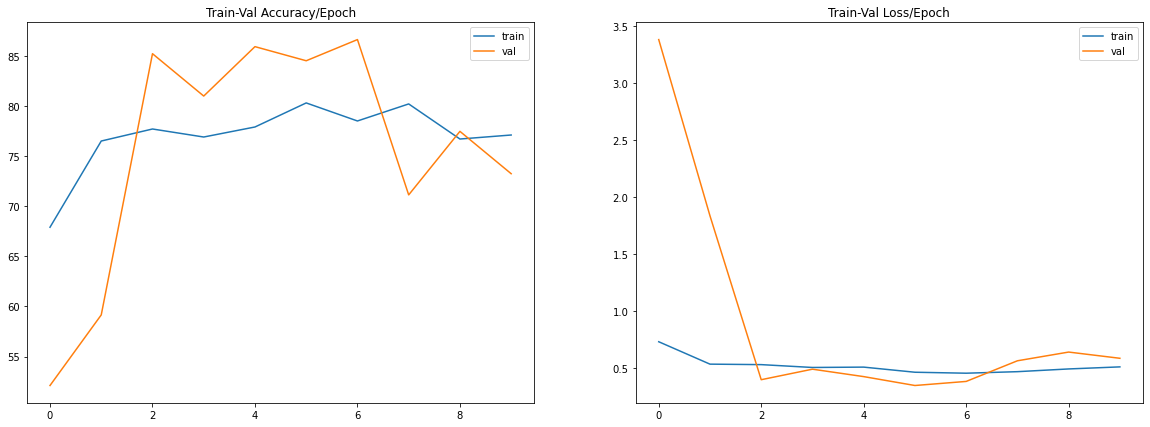

In [54]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
axes[0].plot(train_val_acc_df[train_val_acc_df["variable"]=='train']["epochs"], train_val_acc_df[train_val_acc_df["variable"]=='train']["value"],label = "train")
axes[0].plot(train_val_acc_df[train_val_acc_df["variable"]=='val']["epochs"], train_val_acc_df[train_val_acc_df["variable"]=='val']["value"],label = "val")
axes[0].set_title('Train-Val Accuracy/Epoch')
axes[0].legend()

axes[1].plot(train_val_loss_df[train_val_loss_df["variable"]=='train']["epochs"], train_val_loss_df[train_val_loss_df["variable"]=='train']["value"],label = "train")
axes[1].plot(train_val_loss_df[train_val_loss_df["variable"]=='val']["epochs"], train_val_loss_df[train_val_loss_df["variable"]=='val']["value"],label = "val")
axes[1].legend()
axes[1].set_title('Train-Val Loss/Epoch')

# Test the model

In [68]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

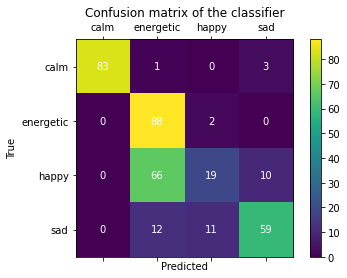

In [78]:
cm = confusion_matrix(y_test, y_pred_list)
confusion_matrix_df = pd.DataFrame(cm).rename(columns=idx2class, index=idx2class)
labels = confusion_matrix_df.columns.tolist()
# plt.imshow(confusion_matrix_df)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
# We want to show all ticks...
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

plt.show()

In [70]:
confusion_matrix_df

,calm,energetic,happy,sad
calm,83,1,0,3
energetic,0,88,2,0
happy,0,66,19,10
sad,0,12,11,59


In [79]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

           0       1.00      0.95      0.98        87
           1       0.53      0.98      0.68        90
           2       0.59      0.20      0.30        95
           3       0.82      0.72      0.77        82

    accuracy                           0.70       354
   macro avg       0.74      0.71      0.68       354
weighted avg       0.73      0.70      0.67       354

